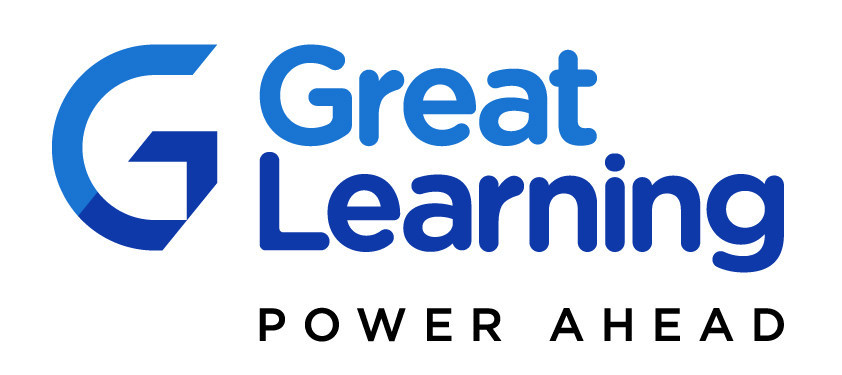

<center>
<h1><b>Classification and Summarization with LLMs</b>
</center>

## Business Scenario

In this case study, we find ourselves in the role of data scientists at Apple. Our task is to support product managers in gathering feedback on MacBooks (and laptops in general) to enhance product design for the upcoming year. Our goal is to identify features to develop, retain, or phase out based on customer preferences. We aim to understand which features resonate with customers, identify areas for improvement, and address any concerns they may have. The primary sources of feedback are customer reviews on e-commerce platforms and YouTube reviews by influencers in the tech industry.

To achieve this objective, we will undertake the following steps:

1. Extract feedback from Amazon reviews and utilize aspect-based sentiment analysis to evaluate sentiment at a granular level, focusing on specific components such as the keyboard, CPU, etc. We will also gather insights about our product as well as competitors'.

2. Extract feedback from tech influencers on YouTube by analyzing transcripts of their videos. This analysis will help us distill key points from their reviews, highlighting what they liked, what they found lacking, and their expectations for future iterations of the product.

Let's start with setting up Anyscale.

## Anyscale Setup

# Setup

Anyscale provides seamless integration with the OpenAI API to provide access to open source models. This is beneficial because we can switch over to Open AI APIs if needed with minimal code changes.

In [1]:
!pip install -q openai==1.23.2 datasets tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


# Authentication

Paste your Anyscale API key in the secrets tab in the left panel.

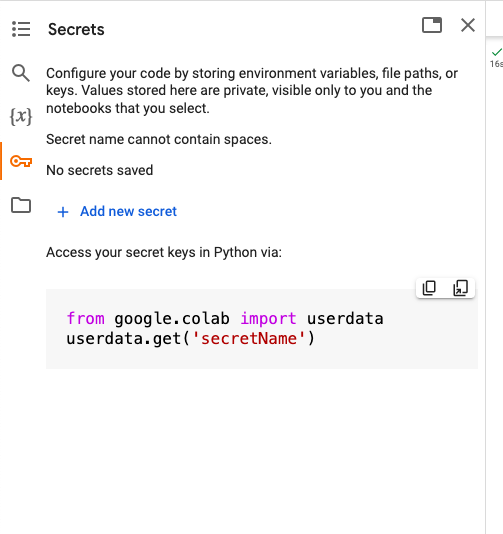

Ensure that you enable notebook access

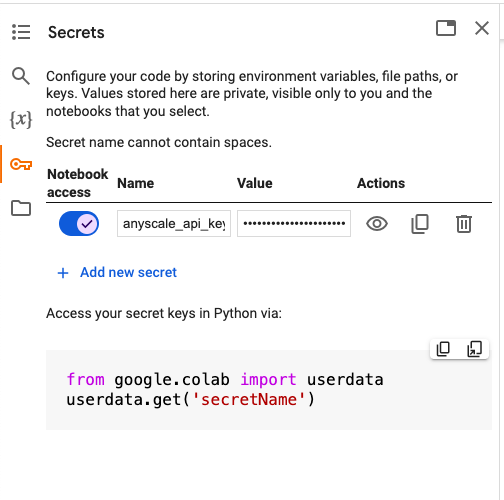

Note that this is a one-time process. The Anyscale API key is now available for all the notebooks linked to this Google account.

In [2]:
import pandas as pd
import numpy as np

from openai import OpenAI
from datasets import load_dataset
import tiktoken
import json
import random


from google.colab import userdata
from tqdm import tqdm
from datasets import load_dataset
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Now we can read the API key from Colab secrets. This way we do not expose our API keys in a notebook.

In [3]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [4]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

We are going to choose the powerful Mixtral 8x7B as our model for the following exercises.

In [5]:
model_name = 'mistralai/Mixtral-8x7B-Instruct-v0.1'

## Utilities

Token counter to keep track of the completion window available in the prompt.

In [6]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

# Auto-Label Classification

## Text $→$ Label generation

A Text $→$ label task (referred to henceforth as classification) involves the categorization of a given input text into a defined set of categories. There are three types of classification tasks:

1. Binary classification: Input text is classified into one of two classes (typically negations). Spam detection & sentiment analysis are examples of binary classification.
2. Multi-class classification: Input text is classified into one of more than two classes. Classifying a customer complaint as one of `critical`, `major` or `minor` is an example of multi-class classification (note that each input can be assigned only one class from the pool of defined classes).
3. Multi-label classification: Input text is classified into one or more labels. Assigning themes to legal documents, such as `Intellectual Property Law`, `Tax Law`, and `Employment Law`, is an example of multi-label classification (note that each input can be assigned multiple classes).


# Problem 1: Component Wise Product Review Analysis

In aspect-based sentiment analysis (ABSA), the aim is to identify the aspects of entities and the sentiment expressed for each aspect. The ultimate goal is to be able to generate a measure of polarity that explicitly accounts for the different aspects of the input. In this way, ABSA presents a nuanced version of the overall polarity of the sentiment expresses in the input. For effective ABSA, we should be able to generate appropriate themes and then assign sentiment to the portions of the input that correspond to this theme.

With respect to our business problem, this would be getting a sentiment for different aspects of the laptop like keyboard, display, performance etc. By recieving sentiment for each aspect instead of gathering overall sentiment, we can find out which aspects of the product are being well recieved and which are not.

### Step 1: Define objectives & Metrics

Unlike a sentiment where we assign positive or negative sentiment to a review, with ABSA we have to consider the additional objective of identifying entities (if any) present in the review.

To evaluate model performance, we judge the accuracy of the aspects + sentiment assignnment per aspect. Note that this is a much more stringent measure compared to the sentiment classification task we have seen so far. For example, if aspects identified by the LLM do not match the ground truth for a specific input, we count this prediction to be incorrect. A correct prediction is one where all the aspects are correctly idenfied and further the sentiment assignment for each aspect is also correctly identified (see figure below).

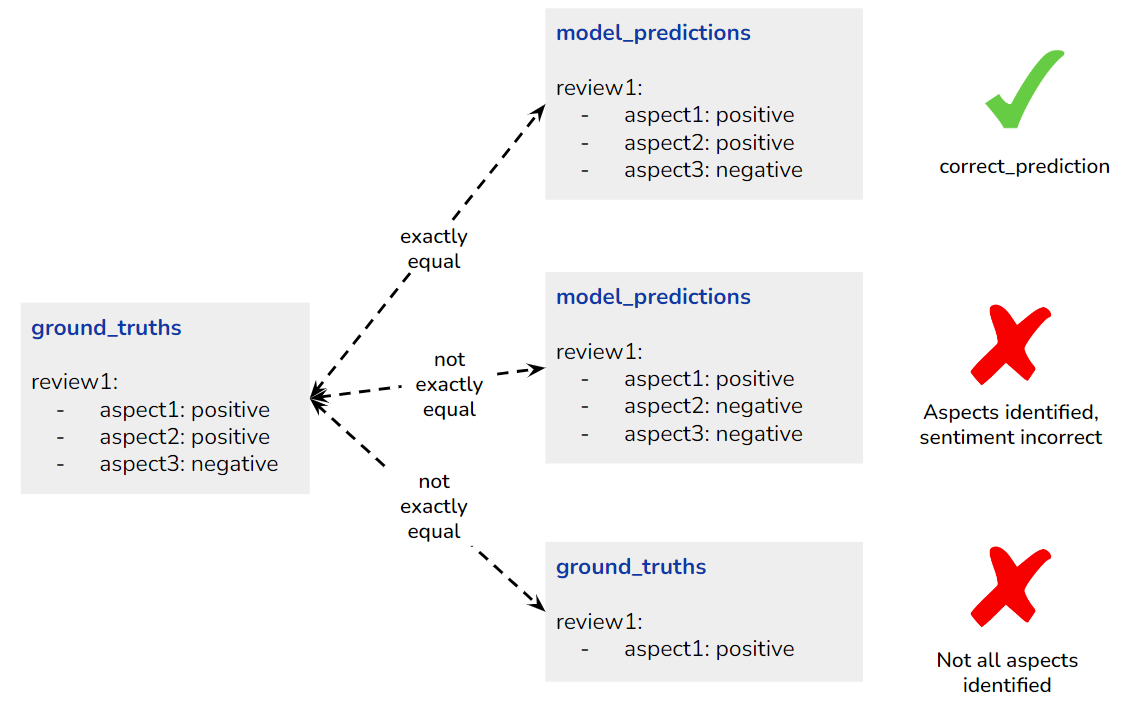

### Step 2: Assemble Data

In [7]:
aspect_based_laptop_corpus = load_dataset("tomaarsen/setfit-absa-semeval-laptops")

Generating train split:   0%|          | 0/2358 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/654 [00:00<?, ? examples/s]

In [8]:
aspect_based_laptop_corpus

DatasetDict({
    train: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 2358
    })
    test: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 654
    })
})

We carve out two sections of the data - one for examples and another for gold examples. We use the gold examples data to test our prompts later while we use the examples to create our few-shot prompt.

In [9]:
laptop_reviews_train_df = aspect_based_laptop_corpus['train'].to_pandas()

In [10]:
laptop_reviews_train_df.sample(10)

,text,span,label,ordinal
277,I bought a protector for my key pad and it wor...,key pad,positive,0
1897,It was hard to handle and operate at school.,operate,negative,0
1343,"I just plug this into my 22"" Monitor and the s...",MacOSX,positive,0
2337,Because he said that the hinge is under the mo...,motherboard,neutral,0
1758,"The PhotoBooth is a great program, it takes ve...",PhotoBooth,positive,0
975,Some problems can be fixed if you purchase new...,software,negative,0
705,It has bein into the shop to get a new hardriv...,touch control buttons,negative,0
296,They sent out the box right away for me to sen...,CD drive,negative,0
428,There is no need to open a program first and t...,program,positive,0
279,It seems they could have updated XP and done w...,XP,positive,0


In [11]:
laptop_reviews_train_df.label.unique()

array(['neutral', 'positive', 'negative', 'conflict'], dtype=object)

Let's remove conflict from the labels as we are only concerned with the three sentiments.

In [12]:
laptop_reviews_train_df = laptop_reviews_train_df[laptop_reviews_train_df['label']!='conflict']

In [13]:
laptop_reviews_train_df['id'] = laptop_reviews_train_df.index

In this dataset, the column span refers to the aspect being discussed in the review. Let's check the number of unique aspects discussed in the reviews.

In [14]:
laptop_reviews_train_df.loc[:, 'span'] = laptop_reviews_train_df['span'].str.lower()

In [15]:
laptop_reviews_train_df.span.nunique()

945

There are way too many aspects. Most of them are infrequent and are useless for the business. Let's focus on top 6 aspects based on the frequency of the aspect. To do that let's check the top most frequent aspects.

In [16]:
laptop_reviews_train_df.span.value_counts()[:15]

span
screen          60
price           56
use             53
battery life    52
keyboard        50
battery         47
programs        37
features        35
software        33
warranty        31
hard drive      30
windows         30
size            24
quality         23
performance     23
Name: count, dtype: int64

We will focus on the following six aspects of the Laptops. These are among the most frequent and are important for the design decisions.

1. Screen
2. Price
3. Battery Life
4. Keyboard
5. Programs
6. Warranty
    
To do this, let's filter our dataset to contain only these aspects.

In [17]:
aspects = ['screen', 'price', 'battery life', 'keyboard', 'programs', 'warranty']
laptop_reviews_train_df = laptop_reviews_train_df[laptop_reviews_train_df['span'].isin(aspects)]

In [18]:
laptop_reviews_train_df.span.unique()

array(['battery life', 'screen', 'price', 'warranty', 'keyboard',
       'programs'], dtype=object)

Let's rename the column to aspect

In [19]:
laptop_reviews_train_df = laptop_reviews_train_df.rename(columns={'span': 'aspect'})

In [20]:
laptop_reviews_examples_df, laptop_reviews_gold_examples_df = train_test_split(
    laptop_reviews_train_df, #<- the full dataset
    test_size=0.2, #<- 50% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

To create this index, we start with a dictionary of aspects in  the task

In [21]:
columns_to_select = [ 'text', 'aspect', 'label']

In [22]:
gold_examples = json.loads((
        laptop_reviews_gold_examples_df.loc[:, columns_to_select]
                                           .sample(30, random_state=42) #<- ensures that gold examples are the same for every session
                                           .to_json(orient='records')
))

In [23]:
gold_examples[0]

{'text': "It has a 10 hour battery life when you're doing web browsing and word editing, making it perfect for the classroom or office, and in terms of gaming and movie playing it'll have a battery life of just over 5 hours.",
 'aspect': 'battery life',
 'label': 'positive'}

### Step 3: Derive Prompt

Now that we have done the preprocessing let's create zero-shot and few-shot prompts for our ABSA.

#### Create prompts

In [24]:
user_message_template = """```{laptop_review}```"""

**Zero-shot prompt**

Let's start with a zero shot prompt for ABSA. Later, we will explore few-shot prompt.

In [25]:
zero_shot_system_message = """
Perform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
For each review presented as input:
- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]}
write the whole sentiment - positive, negative or neutral and not just p,n
"""

In [26]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

In [27]:
num_tokens_from_messages(zero_shot_prompt)

169

Let's create the few-shot prompt right now before evaluating the zero-shot so that we can evaluate zero-shot and few-shot together.

**Few-shot prompt**

The system prompt stays the same as the zero-shot. We are only going to add few examples on top of the system prompt to create the few-shot prompt.

In [28]:
few_shot_system_message = """
Perform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
For each review presented as input:
- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
{
- category:[aspect]
- sentiment:[Sentiment for aspect]}
"""

Let us now look at how we can assemble examples to go along with this few-shot system message and compose a few-shot prompt.

Let's create a function that create examples for each of the selected aspects so that we have examples representign each of the aspects.

In [29]:
def create_examples(dataset, n=2):
    # Define the columns to select from the dataset
    columns_to_select = ['id', 'text','aspect', 'label']

    # Initialize an empty list to store the ids of the examples
    example_ids = []

    # Initialize a dictionary to store the ids of the examples for each aspect
    aspect_index = {
        'battery life': [],
        'screen': [],
        'keyboard': [],
        'price': [],
        'warranty': [],
        'programs': []
    }

    # Loop over the dataset
    for id, aspect in zip(dataset.id, dataset.aspect.str.lower()):
        # For each aspect in the aspect_index dictionary
        for key in aspect_index.keys():
            # If the aspect is in the current row's aspect
            if key in aspect:
                # Append the id of the row to the corresponding aspect in the aspect_index dictionary
                aspect_index[key].append(id)

    # For each aspect in the aspect_index dictionary
    for key in aspect_index:
        # Randomly select 'n' ids from the aspect's list and add them to the example_ids list
        example_ids.extend(np.random.choice(aspect_index[key], n).tolist())

    # Select the rows from the dataset that have their ids in the example_ids list
    examples = dataset.loc[dataset.id.isin(example_ids), columns_to_select]

    # Return the examples as a JSON string
    return examples.to_json(orient='records')

Now, let's create a function that will automatically create a prompt from th system prompt and the examples we have created. We must make sure that the examples are evenly distributed. If they are not evenly distributed, the model might be biased to pick the statements or aspects that are most frequent or the ones that are at the end of the prompt.

In [30]:
def create_prompt(system_message, examples, user_message_template):
    few_shot_prompt = [{'role':'system', 'content': system_message}]

    # Add examples to the prompt after formating them.
    for example in json.loads(examples):
        example_input = example['text']
        example_absa = example['aspect']
        example_label = example['label']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    laptop_review=example_input
                )
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': json.dumps({
                    "category": [example_absa],
                    "polarity": [example_label]
                })
            }
        )

    return few_shot_prompt

In [31]:
examples = create_examples(laptop_reviews_train_df)
few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

Let's have a look at the examples and few-shot prompt we have createed.

In [32]:
examples

'[{"id":16,"text":"\\u00a0One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.","aspect":"screen","label":"negative"},{"id":535,"text":"There are several programs for school or office use (Pages, Numbers, Keynote, etc.), music (Garageband), photo management (Photo Booth, iPhoto), video-editing or movie-making (iMovie), etc.","aspect":"programs","label":"neutral"},{"id":639,"text":"you can find many laptops with the same performance and even better with lower price, but you cannot find the look, easy, applications, and the experience in mac.","aspect":"price","label":"positive"},{"id":848,"text":"There is no number pad to the right of the keyboard which is a bummer.","aspect":"keyboard","label":"negative"},{"id":1410,"text":"I love the easy to see screen, and It works well for work, persoal or just play.","aspect":"screen","label":"positive"},{"id":14

In [33]:
few_shot_prompt

[{'role': 'system',
  'content': "\nPerform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks, that is, ```.\nIn each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.\nFor each review presented as input:\n- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.\n- Assign a sentiment polarity (positive, negative or neutral) for each aspect\n\nArrange your response a JSON object with the following headers:\n{\n- category:[aspect]\n- sentiment:[Sentiment for aspect]}\n"},
 {'role': 'user',
  'content': '```\xa0One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.```'},
 {'role': 'assistant',
  'content': '{"category": ["screen"], "polarity":

Now that we have both the zero-shot and few-shot prompts, let's evaluate them and check which one performs better.

### Evaluate prompts

Let's create a function that can evaluate our prompts by iterating through the gold_examples.

In [34]:
def evaluate_prompt(prompt, gold_examples, user_message_template):
    total_predictions = 0
    correct_predictions = 0

    for example in gold_examples:

        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(laptop_review=example['text'])
            }
        ]

        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=prompt+user_input,
                temperature=0,
                response_format = {"type": "json_object"},

            )
            #print(user_input)
            print(response.choices[0].message.content.strip())
            prediction = json.loads(response.choices[0].message.content.strip())

            categories = prediction['category']
            polarities = prediction['polarity']

            if example['aspect'] in categories:

                index = categories.index(example['aspect'])

                if polarities[index] == example['label']:
                    correct_predictions += 1

            total_predictions += 1

        except Exception as e:
            print("error")
            print(e)
            continue

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    return accuracy

In [35]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template)

{
"category": ["battery life"],
"polarity": {"battery life": "positive"} }
error
0
{
"category": ["screen", "keyboard", "price"],
"polarity": {"screen": "positive", "keyboard": "positive", "price": "negative"} }
error
0
{
"category": ["warranty"],
"polarity": {"warranty": "negative"} }
error
0
{
"category": ["programs"],
"polarity": {"programs": "positive"} }
error
0
{
"category": ["price"],
"polarity": {"price": "negative"} }
error
0
{
"category": ["battery life", "build", "weight"],
"polarity": {"battery life": "positive", "build": "positive", "weight": "positive"} }
error
0
{
"category": ["screen"],
"polarity": {"screen": "negative"} }
error
0
{
"category": ["price"],
"polarity": ["positive"] }
{
"category": ["price", "keyboard", "screen", "programs"],
"polarity": {"price": "neutral", "keyboard": "positive", "screen": "positive", "programs": "positive"} }
error
2
{
"category": ["programs"],
"polarity": {"programs": "negative"} }
error
0
{
"category": ["price"],
"polarity": {"price":

1.0

Although the model successfully conducts Aspect-Based Sentiment Analysis (ABSA), it does not generate the output in the desired format and hence is running into errors. Our request was for sentiments to be presented as a list within the dictionary; however, the model outputs a dictionary of sentiments nested within the output dictionary. Even the response format option cannot help us here. We have two potential approaches to rectify this issue: we can adjust the function to accommodate the model's output, or we can explore a few-shot approach to prompt the model to provide output in the specified format.

Let's explore few-shot and check how it does.

In [42]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"

0.8666666666666667

We can see that few-shot prompting does a much better job. However it is only outputting one sentiment even when there are multiple aspects detected (This might not be observable every iteration). We would ideally want the model to output individual sentiment for each aspect. Let's change the few-shot examples to modify the model behaviour. Since our data doesn't have multiple aspects, let's manually create a few-shot prompt in such a way that we add multiple aspects and multiple sentiments for some of the examples.

In [43]:
few_shot_manual_prompt =[
 {'role': 'system',
  'content': """\nPerform aspect based sentiment analysis on laptop reviews presented in the input delimited by triple backticks,
   that is, ```.\nIn each review there might be one or more of the following aspects: 'battery life', 'screen', 'keyboard', 'price', 'warranty','programs'.
   \nFor each review presented as input:\n- Identify if there are any of the 6 aspects ('battery life', 'screen', 'keyboard', 'price', 'warranty', 'programs') present in the review.
   \n- Assign a sentiment polarity (positive, negative or neutral) for each aspect\n
   If there are multiple aspects there should be a corresponding sentiment for each aspect.
   \nArrange your response a JSON object with the following headers:\n{\n- category:[aspect]\n- sentiment:[Sentiment for aspect]}\n"""},
 {'role': 'user',
  'content': '```The keyboard feels good and I type just fine on it.```'},
 {'role': 'assistant',
  'content': '{"category": ["keyboard"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': '```It is loaded with programs that is of no good for the average user, that makes it run way to slow. I have had it for about a 1 1/2 and yes I have had an issue with it one month out of warranty.```'},
 {'role': 'assistant',
  'content': '{"category": ["programs", "warranty"], "polarity": ["negative", "neutral"]}'},
 {'role': 'user',
  'content': '```Overall the computer is very easy to use, the screen is perfect, great computer, my daughter loves.```'},
 {'role': 'assistant',
  'content': '{"category": ["screen"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': "```It didn't take me long to get switched over to the Mac computer programs and navigation - it's been just fine and like the way this laptop functions much better.```"},
 {'role': 'assistant',
  'content': '{"category": ["programs"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': "```:-)If you buy this - don't go into it expecting 7 hrs of battery life, and you'll be perfectly satisfied. But Keyboard is reasonable size```"},
 {'role': 'assistant',
  'content': '{"category": ["battery life","keyboard"], "polarity": ["negative","positive"]}'},
 {'role': 'user',
  'content': '```I wiped nearly everything off of it, installed OpenOffice and Firefox, and I am operating an incredibly efficient and useful machine for a great price.```'},
 {'role': 'assistant',
  'content': '{"category": ["price"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': "```I use this for my tutoring business, and since I'm always bouncing from student to student, it is ideal for portability and battery life (yes, it gets the 8 hours as advertised!).```"},
 {'role': 'assistant',
  'content': '{"category": ["battery life"], "polarity": ["positive"]}'},
 {'role': 'user',
  'content': '```The battery life sucked the juice from my laptop and when the extended life battery went out we were SOL there to, so much for that warranty covering all the products we purchased.```'},
 {'role': 'assistant',
  'content': '{"category": ["warranty"], "polarity": ["negative"]}'},
 {'role': 'user',
  'content': "```The fact that the screen reacts to the lighting around you is an added luxury-when you are working around others in dark areas and want privacy or don't want to bother them with bright lighting, it is very convenient to have a darker, softer lit screen. And Price and purpose is awesome!```"},
 {'role': 'assistant',
  'content': '{"category": ["screen","price"], "polarity": ["positive","positive"]}'}]


In [47]:
evaluate_prompt(few_shot_manual_prompt, gold_examples, user_message_template)

{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs", "keyboard"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life", "build", "weight"], "polarity": ["positive", "positive", "positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["positive"]}
error
list index out of range
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs", "trackpad"], "polarity": ["positive"]}
{"category": ["screen", "programs"], "polarity": ["positive", "positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative", "negative"]}

0.8275862068965517

We can see that there is some improvement in the model's response. In some cases, we can see multiple sentiments where there are multiple aspects. Let's now check the performance across multiple runs.

In [44]:
num_eval_runs = 5

In [49]:
few_shot_performance = []

In [46]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(laptop_reviews_train_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]

{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard"], "polarity": ["negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}


 20%|██        | 1/5 [00:59<03:57, 59.31s/it]

{"category": ["programs"], "polarity": ["positive"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen", "keyboard"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price", "screen"], "polarity": ["positive"]}
error
list index out of range
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}

 40%|████      | 2/5 [01:57<02:55, 58.37s/it]

{"category": ["programs"], "polarity": ["positive"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["neutral"]}


 60%|██████    | 3/5 [02:51<01:53, 56.63s/it]

{"category": ["programs"], "polarity": ["positive"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard"], "polarity": ["negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"categor

 80%|████████  | 4/5 [03:50<00:57, 57.42s/it]

{"category": ["programs"], "polarity": ["positive"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["warranty"], "polarity": ["negative"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["negative"]}
{"category": ["battery life"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["negative"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["price"], "polarity": ["positive"]}
{"category": ["programs"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["positive"]}
{"category": ["keyboard", "screen"], "polarity": ["negative"]}
{"category": ["keyboard"], "polarity": ["positive"]}
{"category": ["screen"], "polarity": ["negative"]}

100%|██████████| 5/5 [04:47<00:00, 57.52s/it]

{"category": ["programs"], "polarity": ["positive"]}


In [48]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.8321839080459771, 0.02120681867723919)

We can see how important few-shot prompting is. It is necessary in this case to get the output from LLM in the required format. Hence, few-shot-prompting is the obvious choice for this task. Stronger models will do a better job at outputting multiple sentiments for multiple aspects. However, they are very large and incur higher maintainance costs in terms of hardware.

Using few-shot, we were able to get aspect based sentiments which can then be analysed by stakeholders to figure out what features of the product needs improvement.

Let's move on to the Youtube tech channel review analysis. We need to understand from the youtube influencers the general opinon about our product. We need to understand which features are taken well by the users and which are not. This allows the product managers to make better design decisions.

# Problem 2: Youtube Tech-Channel Review Analysis

Let's start with importing the dataset.

## Step 1 - Importing Data

In [51]:
transcripts = pd.read_csv("youtube_transcripts.csv")

In [52]:
transcripts.head()

,ID,Title,transcript
0,1,Here's the Thing about the M3 Macbook Air...,Intro\n(Intro music)\n- That's crazy that the ...
1,2,"15"" MacBook Air M2 Review: The Obvious Thing!",Intro\n(upbeat music)\n- What's up?\nMKBHD her...
2,3,Apple finally got revenge - MacBook Air M2,this is a MacBook Air M1 it's an\ninteresting ...
3,4,M2 MacBook Air Review: More Than a Refresh!,"(upbeat music)\n- All right, what's up? MKBHD ..."
4,5,M2 MacBook Air vs. The Rest,i have an interesting story so two years\n\nag...


We have ten youtube transcritps on Macbook Air by various tech influencers. We are going to use this small dataset as a base to build our model. It is easy to see that the same process we build is scalable to large number of examples.

The product designers have come up with the following set of insights they want to extract from the transcripts.

**'Liked Features':** List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.

**'Disliked Features':** List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.

**'Future Requirements':** Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.

**'Overall Sentiment':** Identify the overall sentiment of the video. It should be a single word 'positive' or 'negative' or 'neutral'.

**'Competitor Mention':** Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in the review.

**'Competitor Sentiment':** Determine the sentiment expressed by the influencer towards competitor laptops (positive, negative, neutral).

**'Feature Importance':** List down the most important features from top to bottom.

**'Summary':** Provide a concise summary of the review, highlighting the key points and takeaways.

## Step 2 - Create prompts

In [53]:
user_message_template = """```{transcript}```"""

**Zero-shot prompt**

Let's create a zero shot prompt that extracts the required insights from the transcript.

Let's check if we can achieve this with Zero-Shot Prompting.

In [54]:
zero_shot_system_message = """You are a product manager reviewing market opinion on your product - Macbook Air.
Analyze the provided YouTube transcript of a tech-influencer reviewing Apple laptops. Extract the following information:

'Liked Features': List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.
'Disliked Features': List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.
'Future Requirements': Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.
'Overall Sentiment': Identify the overall sentiment of the video. It should be a single word 'positive' or 'negative' or 'neutral'.
'Competitor Mention': Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in the review.
'Competitor Sentiment': Determine the sentiment expressed by the influencer towards competitor laptops (positive, negative, neutral).
'Feature Importance': List down the most important features from top to bottom.
'Summary': Provide a concise summary of the review, highlighting the key points and takeaways.
Output Format:

Return the extracted information in a JSON object with the following structure:

The output should only have the json output enclosed in '{}'. Do not explain your answer.

{
  "Liked Features": [...],
  "Disliked Features": [...],
  "Future Requirements": [...],
  "Overall Sentiment": "..."
  "Competitor Mention": [...],
  "Competitor Sentiment": "...",
  "Feature Importance": {...},
  "Summary": "..."
}

"""

In [55]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

Let's check the number of tokens our zero_shot_prompt takes. We need to keep a check on this to optimise our costs.


In [56]:
num_tokens_from_messages(zero_shot_prompt)

331

In [57]:
messages=[
    {"role": "system", "content": zero_shot_system_message},
    {"role": "user", "content": transcripts.transcript[0]}
]
print(messages)

[{'role': 'system', 'content': 'You are a product manager reviewing market opinion on your product - Macbook Air.\nAnalyze the provided YouTube transcript of a tech-influencer reviewing Apple laptops. Extract the following information:\n\n\'Liked Features\': List the features mentioned by the influencer that they liked or appreciated about the Apple laptops.\n\'Disliked Features\': List the features mentioned by the influencer that they disliked or had issues with about the Apple laptops.\n\'Future Requirements\': Identify any specific requirements or features that the influencer mentioned they would like to see in future Apple laptops.\n\'Overall Sentiment\': Identify the overall sentiment of the video. It should be a single word \'positive\' or \'negative\' or \'neutral\'.\n\'Competitor Mention\': Identify any mentions of competitor laptops (e.g. Dell, HP, Lenovo) made by the influencer in the review.\n\'Competitor Sentiment\': Determine the sentiment expressed by the influencer towa

Let's test our prompt with a single example. If it turns out successful, we can run it through all the transcripts.

In [58]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": zero_shot_system_message},
        {"role": "user", "content": transcripts.transcript[0]}
    ],

    response_format = {"type": "json_object"}
    # Setting response format to json makes the LLM produce JSON objects and makes processing complex LLM outputs easy.
    # This is an option available only for mistral models
)

In [59]:
print(response.choices[0].message.content)

{
  "Liked Features": ["New anodization on the outside", "M3 chip", "10-20% improvement in performance", "Graphics improvements", "Rate tracing", "Dual external display support", "Improved base storage on M3", "Great battery life"],
  "Disliked Features": ["Still gets fingerprints", "Lowered price of M2 by a hundred bucks and discontinued the M1", "High markup prices for above base spec", "Historically easy to recommend but not with this M3 Air"],
  "Future Requirements": ["More reasonable pricing for upgrades", "Continuation of M1 for budget options"],
  "Overall Sentiment": "Negative",
  "Competitor Mention": [],
  "Competitor Sentiment": [],
  "Feature Importance": {
    "Performance": 1,
    "Price": 2,
    "Upgrade Options": 3
  },
  "Summary": "The reviewer discusses the new MacBook Air with a negative sentiment, citing high markup prices for upgrades and the lowered price of the M2 model. The reviewer appreciates the performance improvements but recommends users to opt for the M

Great! It works smoothly and is producing the output in the required format. We can go ahead and scale the process to all the examples.

In [60]:
def json_to_dataframe(transcripts, client, model_name, zero_shot_system_message):

    """
    Converts transcripts into a DataFrame by utilizing a language model to generate JSON responses.

    Args:
        transcripts (DataFrame): DataFrame containing transcripts.
        client: Object representing the OpenAI API client.
        model_name (str): Name of the language model to use for response generation.
        zero_shot_system_message (str): System message for zero-shot learning.

    Returns:
        DataFrame: DataFrame containing JSON responses generated from the transcripts.
    """
    # Initialize an empty list to store the JSON responses
    json_responses = []

    # Iterate over the transcripts in the DataFrame
    for transcript in transcripts['transcript']:
        # Create the messages list
        messages = [
            {"role": "system", "content": zero_shot_system_message},
            {"role": "user", "content": transcript}
        ]

        # Get the chat completion
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            response_format = {"type": "json_object"},
            temperature = 0
        )
        # print(response.choices[0].message.content) # uncomment to check the response of the LLM individually for each transcript.
        response = json.loads(response.choices[0].message.content.strip())
        # Add the JSON response to the list
        json_responses.append(response)

    # Convert the list of JSON responses to a DataFrame
    json_df = pd.DataFrame(json_responses)

    return json_df

In [61]:
final = json_to_dataframe(transcripts,client,model_name, zero_shot_system_message)

Let's check the dataframe created from LLM outputs.

In [62]:
final

,Liked Features,Disliked Features,Future Requirements,Overall Sentiment,Competitor Mention,Competitor Sentiment,Feature Importance,Summary
0,"[New anodization on the outside, M3 chip, 10-2...","[Fingerprint resistance not much different, Sa...",[More reasonable pricing for upgrades],Mixed,[],[],"{'Performance': 1, 'Battery Life': 2, 'Storage...",The reviewer discusses the new MacBook Air wit...
1,"[15-inch screen size, Similar design as 14-inc...","[No face ID, No heatsink, Potential for therma...",[],Positive,"[Windows laptops, XPF 15, ROG Zephyrus, Flippi...",Neutral,"{'15-inch screen size': 1, 'Similar design as ...",The review is positive towards the 15-inch Mac...
2,"[M2 chip, 13.6 inch display, DCI P3 color spac...","[Base model has slow SSD, 720p webcam on M1 Ma...","[Faster SSD in base model, 1080p webcam, Consi...",Positive,"[Dell, HP, Lenovo]",Neutral,"{'M2 Chip': 1, 'Display': 2, 'Performance': 3,...",The influencer generally has a positive opinio...
3,[Thinner and flat design of the new MacBook Ai...,[Only two USB type C Thunderbolt 3 ports on th...,"[USB type C ports on both sides, Improved SSD ...",Positive,[],Neutral,"{'Design': 1, 'Performance': 2, 'Battery Life'...",The reviewer appreciates the new thinner and f...
4,"[fantastic performance, great keyboard, great ...","[more expensive device, throttles at the top e...","[better gpu and battery life, upgradeable stor...",positive,"[windows alternatives, xps 13 plus, asus zenbo...",positive,"{'fantastic performance': 1, 'great keyboard':...",The tech influencer has a positive sentiment t...
5,"[Lightweight and portable design, Good battery...","[Chipping finish around ports, Fingerprint mag...","[Improved webcam, Better rubber feet, Support ...",Positive,[],[],"{'Lightweight and portable design': 1, 'Good b...",The review is positive towards the M2 MacBook ...
6,"[New M2 chip, Nice design aesthetics, Thinner ...",[Not as powerful as M2 MacBook Pro for extende...,"[Improved heat management for fanless system, ...",Positive,[],Neutral,"{'Performance': 1, 'Design': 2, 'Keyboard': 3,...",The reviewer has a positive sentiment towards ...
7,"[Physically held up well, Thin and light, Soli...","[Both Thunderbolt ports on the same side, Only...","[Mini LED 120Hz display, Upgraded M3 MacBook Air]",Positive,[Windows laptops],Neutral,"{'Bright screen': 1, 'Long battery life': 2, '...",The influencer has a positive opinion about th...
8,"[Stunning design, Lightweight and thin, Magsaf...","[Easily smudges and scratches, Only 60 Hz refr...",[Improved build material to prevent smudging a...,Positive,[],Neutral,"{'Stunning design': 1, 'Lightweight and thin':...",The reviewer has a positive opinion about the ...
9,"[Starlight color doesn't show fingerprints, Li...",[Base model with 8GB RAM and 256GB SSD may not...,"[Considering user needs, sufficient RAM and st...",Positive,[],Neutral,"{'Performance': 1, 'Design & Aesthetics': 2, '...",The reviewer has a positive sentiment towards ...


This looks good but it is difficult to manually judge the output given the transcripts are long. Let's evaluate the performance of the LLM to make sure our pipeline is doing a good job.

### Step 3 - Evaluation

Let's use a bigger model to grade the responses provided by mixtral.

In [63]:
rater_model = "meta-llama/Meta-Llama-3-70B-Instruct"

Let's create a step-by-step instruction for the rater model to perform rating on mixtral responses.

In [64]:
rater_system_message = """
You are tasked with rating AI-generated jsons of youtube transcripts based on the given metric.
You will be presented a transcript and an AI generated json of the transcript as the input.
In the input, the transcript will begin with ###transcript while the AI generated json will begin with ###json.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
For each heading in the json, check if the output in that heading is true to the transcript.
The json should have all the following headings: ["Liked Features", "Disliked Features", "Future Requirements", "Overall Sentiment" "Competitor Mention", "Competitor Sentiment", "Feature Importance", "Summary"]
The json should cover all the aspects that are majorly being discussed in the transcript.

Instructions:
1. First write down the steps that are needed to evaluate the output as per the metric.
2. Give a step-by-step explanation if the output adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the output using the evaluaton criteria and assign a score.
"""

In [65]:
rater_user_message_template = """
###transcript
{transcript}

###json
{output}
"""

Let's iterate through our mixtral responses and get each one rated by Llama3.

In [66]:
ratings = []
for transcript, output in tqdm(zip(transcripts.transcript, final.iterrows())):
    # Iterated through the transcripts and the LLM responses stored in dataframe
    # and rates each of them based on the specified metrics.
    rater_prompt = [
        {'role': 'system',
         'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                transcript=transcript,
                output=output
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )
    ratings.append(response.choices[0].message.content)

10it [03:51, 23.15s/it]


Let's check a rating provided by Llama - 3.

In [67]:
ratings[8]

'Here are the steps to evaluate the output as per the metric:\n\n1. Check if the JSON output has all the required headings: ["Liked Features", "Disliked Features", "Future Requirements", "Overall Sentiment", "Competitor Mention", "Competitor Sentiment", "Feature Importance", "Summary"].\n2. For each heading, check if the output is true to the transcript. For example, under "Liked Features", the output should mention the features that the reviewer liked, which are mentioned in the transcript.\n3. Check if the JSON output covers all the major aspects discussed in the transcript.\n\nNow, let\'s evaluate the output step by step:\n\n1. The JSON output has all the required headings.\n2. "Liked Features": The output mentions "Stunning design", "Lightweight and thin", and "Magsafe" as liked features, which are all mentioned in the transcript as positive aspects of the M2 MacBook Air. (True)\n3. "Disliked Features": The output mentions "Easily smudges and scratches" and "Only 60 Hz refresh rate

In [68]:
final["rating"] = ratings
final.head()

,Liked Features,Disliked Features,Future Requirements,Overall Sentiment,Competitor Mention,Competitor Sentiment,Feature Importance,Summary,rating
0,"[New anodization on the outside, M3 chip, 10-2...","[Fingerprint resistance not much different, Sa...",[More reasonable pricing for upgrades],Mixed,[],[],"{'Performance': 1, 'Battery Life': 2, 'Storage...",The reviewer discusses the new MacBook Air wit...,Here are the steps to evaluate the output as p...
1,"[15-inch screen size, Similar design as 14-inc...","[No face ID, No heatsink, Potential for therma...",[],Positive,"[Windows laptops, XPF 15, ROG Zephyrus, Flippi...",Neutral,"{'15-inch screen size': 1, 'Similar design as ...",The review is positive towards the 15-inch Mac...,**Step-by-Step Evaluation**\n\n1. **Check if t...
2,"[M2 chip, 13.6 inch display, DCI P3 color spac...","[Base model has slow SSD, 720p webcam on M1 Ma...","[Faster SSD in base model, 1080p webcam, Consi...",Positive,"[Dell, HP, Lenovo]",Neutral,"{'M2 Chip': 1, 'Display': 2, 'Performance': 3,...",The influencer generally has a positive opinio...,Here are the steps to evaluate the output as p...
3,[Thinner and flat design of the new MacBook Ai...,[Only two USB type C Thunderbolt 3 ports on th...,"[USB type C ports on both sides, Improved SSD ...",Positive,[],Neutral,"{'Design': 1, 'Performance': 2, 'Battery Life'...",The reviewer appreciates the new thinner and f...,Here are the steps to evaluate the output as p...
4,"[fantastic performance, great keyboard, great ...","[more expensive device, throttles at the top e...","[better gpu and battery life, upgradeable stor...",positive,"[windows alternatives, xps 13 plus, asus zenbo...",positive,"{'fantastic performance': 1, 'great keyboard':...",The tech influencer has a positive sentiment t...,Here are the steps to evaluate the output as p...


These detailed ratings could be used to diagnose issues with the prompt or the model used. You can iteratively improve the prompt to get the desired output quality.

Our model seems to do a decent job as the ratings from Llama suggest. This process can further be scaled with a larger dataset of youtube trascripts.

Together, the review analysis and transcript analysis provides important insights to the product managers regarding the market opinion on their product.

**Power Ahead!**